In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST WA 2016


##### Results are divided across two files, one for statewide results, one for U.S. House results.
##### This file deals with statewide results


## VEST Documentation


### Election Results


#### Sources

Election results from Washington Secretary of State (https://www.sos.wa.gov/elections/research/election-results-and-voters-pamphlets.aspx)

#### Processing

A few dozen votes were reported countywide in King County and Pierce County, these were distributed by candidate to precincts based on their share of the precinct-level reported vote.



## Election Results Processing

#### Load in the VEST file

In [2]:
wa_vest = gp.read_file("raw-from-source/wa_2016/wa_2016.shp")

In [3]:
wa_vest.crs

<Projected CRS: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington South (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

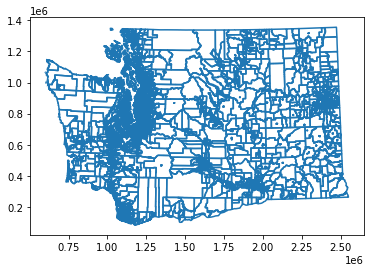

In [4]:
wa_vest.boundary.plot()

In [5]:
wa_vest.columns

Index(['LEGDIST', 'CONGDIST', 'CCDIST', 'COUNTY', 'COUNTYCODE', 'PRECCODE',
       'PRECNAME', 'ST_CODE', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE', 'G16PRECCAS', 'G16PREOKEN', 'G16PREOLAR', 'G16USSDMUR',
       'G16USSRVAN', 'G16GOVDINS', 'G16GOVRBRY', 'G16LTGDHAB', 'G16LTGRMCC',
       'G16SOSDPOD', 'G16SOSRWYM', 'G16TRERWAI', 'G16TRERDAV', 'G16AUDDMCC',
       'G16AUDRMIL', 'G16ATGDFER', 'G16ATGRTRU', 'G16LNDDFRA', 'G16LNDRMCL',
       'G16INSDKRE', 'G16INSRSCH', 'geometry'],
      dtype='object')

In [6]:
wa_vest.head(5)

,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,G16PREDCLI,G16PRERTRU,...,G16TRERDAV,G16AUDDMCC,G16AUDRMIL,G16ATGDFER,G16ATGRTRU,G16LNDDFRA,G16LNDRMCL,G16INSDKRE,G16INSRSCH,geometry
0,9,4,1,Adams,AD,111,Ritzville Ward 1,AD00000111,24,109,...,81,45,92,57,66,27,107,40,89,"POLYGON ((2169598.057 664568.324, 2169604.801 ..."
1,9,4,1,Adams,AD,112,Ritzville Ward 2,AD00000112,26,96,...,65,35,87,66,51,30,92,40,84,"POLYGON ((2170310.521 663414.822, 2170266.610 ..."
2,9,4,1,Adams,AD,113,Ritzville Ward 3,AD00000113,56,117,...,102,51,128,90,82,49,134,59,119,"POLYGON ((2170888.692 661269.850, 2170899.305 ..."
3,9,4,1,Adams,AD,114,Ritzville Ward 4,AD00000114,54,113,...,83,60,110,76,73,47,122,62,104,"POLYGON ((2169653.861 660147.393, 2169696.591 ..."
4,9,4,1,Adams,AD,115,Ritzville Ward 5,AD00000115,48,123,...,98,45,125,85,71,38,136,52,119,"POLYGON ((2170366.691 658815.191, 2170391.676 ..."


In [7]:
wa_vest.shape

(7195, 34)

#### make sure ST_CODE is a unique_id column

In [8]:
assert(len(wa_vest['ST_CODE']) == len(wa_vest['ST_CODE'].unique()))

## Election Results

### Load, Clean, Pivot Election Results

#### Load in the Secretary of State general election results for 2016 

In [9]:
wa_election_results = pd.read_csv('raw-from-source/2016Gen_Precinct_Results_GIS-Ready.csv')


In [10]:
display(wa_election_results)

,PrecinctCode,CONGDIST,G16I1433Y,G16I1433N,G16I1464Y,G16I1464N,G16I1491Y,G16I1491N,G16I1501Y,G16I1501N,...,G16481KUDE,G16481DARN,G16482MCBR,G16482PHEL,G1649SCLEV,G1649SGERH,G16491WYLI,G16491BECK,G16492STON,G16492TOPP
0,AD00000111,4,67,73,45,87,59,81,89,44,...,0,0,0,0,0,0,0,0,0,0
1,AD00000112,4,53,73,53,70,80,46,95,28,...,0,0,0,0,0,0,0,0,0,0
2,AD00000113,4,72,124,63,118,109,81,137,55,...,0,0,0,0,0,0,0,0,0,0
3,AD00000114,4,68,105,68,94,100,73,123,49,...,0,0,0,0,0,0,0,0,0,0
4,AD00000115,4,58,128,58,118,108,79,122,62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,YA00005014,4,196,386,195,355,275,302,425,152,...,0,0,0,0,0,0,0,0,0,0
7121,YA00005016,4,120,210,115,203,185,147,237,87,...,0,0,0,0,0,0,0,0,0,0
7122,YA00005020,4,102,253,112,224,184,171,215,137,...,0,0,0,0,0,0,0,0,0,0
7123,YA00005101,4,86,194,107,157,155,123,207,71,...,0,0,0,0,0,0,0,0,0,0


#### make sure PrecinctCode is a unique id column

In [11]:
assert(len(wa_election_results['PrecinctCode']) == len(wa_election_results['PrecinctCode'].unique()))

In [12]:
# race codes for relavant races in the VEST file
race_codes = [
    'G16PREDCLI',
    'G16PRERTRU',
    'G16PREOKEN',
    'G16PREOLAR',
    'G16PREGSTE',
    'G16PRECCAS', 
    'G16PRELJOH',
    
    'G16USSDMUR', 
    'G16USSRVAN',
    
    'G16GOVDINS',
    'G16GOVRBRY',
       
    'G16LTGDHAB', 
    'G16LTGRMCC',
    
    'G16SOSDPOD',
    'G16SOSRWYM', 
       
    'G16TRERWAI',
    'G16TRERDAV',  
    
    'G16AUDDMCC',
    'G16AUDRMIL',
        
    'G16ATGDFER', 
    'G16ATGRTRU',
       
    'G16LNDDFRA',
    'G16LNDRMCL',  
    
    'G16INSDKRE',
    'G16INSRSCH'
]

#### Select relevant races from the election results, as well as the unique PrecinctCode column

In [13]:

race_columns = [
    'PrecinctCode',
    'G16PRSCLIN', 
    'G16PRSTRUM', 
    'G16PRSKENN', 
    'G16PRSLARI', 
    'G16PRSSTEI',
    'G16PRSCAST', 
    'G16PRSJOHN', 
    'G16SENMURR', 
    'G16SENVANC',
    'G16GOVINSL', 
    'G16GOVBRYA', 
    'G16LTGHABI', 
    'G16LTGMCCL', 
    'G16SOSWYMA',
    'G16SOSPODL', 
    'G16TREDAVI', 
    'G16TREWAIT', 
    'G16AUDMILO', 
    'G16AUDMCCA', 
    'G16ATGFERG', 
    'G16ATGTRUM', 
    'G16CPLMCLA',
    'G16CPLFRAN', 
    'G16INCKREI', 
    'G16INCSCHR'
]

wa_elec = wa_election_results[race_columns]
display(wa_elec)


,PrecinctCode,G16PRSCLIN,G16PRSTRUM,G16PRSKENN,G16PRSLARI,G16PRSSTEI,G16PRSCAST,G16PRSJOHN,G16SENMURR,G16SENVANC,...,G16TREDAVI,G16TREWAIT,G16AUDMILO,G16AUDMCCA,G16ATGFERG,G16ATGTRUM,G16CPLMCLA,G16CPLFRAN,G16INCKREI,G16INCSCHR
0,AD00000111,24,109,0,0,1,2,4,53,86,...,81,50,92,45,57,66,107,27,40,89
1,AD00000112,26,96,0,0,0,3,1,44,82,...,65,42,87,35,66,51,92,30,40,84
2,AD00000113,56,117,0,0,1,0,12,87,109,...,102,66,128,51,90,82,134,49,59,119
3,AD00000114,54,113,1,1,1,3,8,67,114,...,83,63,110,60,76,73,122,47,62,104
4,AD00000115,48,123,0,0,1,1,10,66,117,...,98,56,125,45,85,71,136,38,52,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,YA00005014,132,412,1,0,3,7,21,193,394,...,275,233,395,149,255,272,429,123,153,387
7121,YA00005016,78,228,1,0,9,10,12,111,218,...,173,139,221,101,149,162,246,80,112,208
7122,YA00005020,95,240,1,0,4,1,16,126,233,...,163,148,255,88,168,155,264,79,114,224
7123,YA00005101,91,176,0,0,2,0,14,95,185,...,131,115,190,73,138,109,200,67,91,172


#### Create a name change dictionary for the columns to match VEST, and rename the columns of the SoS file

In [14]:
source_race_to_vest_race = {
    'PrecinctCode': 'ST_CODE',
    'G16PRSCLIN': 'G16PREDCLI', 
    'G16PRSTRUM': 'G16PRERTRU', 
    'G16PRSKENN': 'G16PREOKEN', 
    'G16PRSLARI': 'G16PREOLAR', 
    'G16PRSSTEI': 'G16PREGSTE',
    'G16PRSCAST': 'G16PRECCAS', 
    'G16PRSJOHN': 'G16PRELJOH', 
    'G16SENMURR': 'G16USSDMUR', 
    'G16SENVANC': 'G16USSRVAN',
    'G16GOVINSL': 'G16GOVDINS', 
    'G16GOVBRYA': 'G16GOVRBRY', 
    'G16LTGHABI': 'G16LTGDHAB', 
    'G16LTGMCCL': 'G16LTGRMCC', 
    'G16SOSWYMA': 'G16SOSRWYM',
    'G16SOSPODL': 'G16SOSDPOD', 
    'G16TREDAVI': 'G16TRERDAV', 
    'G16TREWAIT': 'G16TRERWAI', 
    'G16AUDMILO': 'G16AUDRMIL', 
    'G16AUDMCCA': 'G16AUDDMCC', 
    'G16ATGFERG': 'G16ATGDFER', 
    'G16ATGTRUM': 'G16ATGRTRU', 
    'G16CPLMCLA': 'G16LNDRMCL',
    'G16CPLFRAN': 'G16LNDDFRA', 
    'G16INCKREI': 'G16INSDKRE', 
    'G16INCSCHR': 'G16INSRSCH'
}

wa_elec.rename(columns=source_race_to_vest_race, inplace=True)
display(wa_elec)

/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ST_CODE,G16PREDCLI,G16PRERTRU,G16PREOKEN,G16PREOLAR,G16PREGSTE,G16PRECCAS,G16PRELJOH,G16USSDMUR,G16USSRVAN,...,G16TRERDAV,G16TRERWAI,G16AUDRMIL,G16AUDDMCC,G16ATGDFER,G16ATGRTRU,G16LNDRMCL,G16LNDDFRA,G16INSDKRE,G16INSRSCH
0,AD00000111,24,109,0,0,1,2,4,53,86,...,81,50,92,45,57,66,107,27,40,89
1,AD00000112,26,96,0,0,0,3,1,44,82,...,65,42,87,35,66,51,92,30,40,84
2,AD00000113,56,117,0,0,1,0,12,87,109,...,102,66,128,51,90,82,134,49,59,119
3,AD00000114,54,113,1,1,1,3,8,67,114,...,83,63,110,60,76,73,122,47,62,104
4,AD00000115,48,123,0,0,1,1,10,66,117,...,98,56,125,45,85,71,136,38,52,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,YA00005014,132,412,1,0,3,7,21,193,394,...,275,233,395,149,255,272,429,123,153,387
7121,YA00005016,78,228,1,0,9,10,12,111,218,...,173,139,221,101,149,162,246,80,112,208
7122,YA00005020,95,240,1,0,4,1,16,126,233,...,163,148,255,88,168,155,264,79,114,224
7123,YA00005101,91,176,0,0,2,0,14,95,185,...,131,115,190,73,138,109,200,67,91,172


#### Distribute countywide votes from Kings and Pierce counties

Create a county column using the first two letters of the unique ST_CODE

In [15]:
wa_elec["county"] = wa_elec["ST_CODE"].str[0:2]

pi_ki_precincts = wa_elec[wa_elec["county"].isin(["PI","KI"])]
not_pi_ki_precincts = wa_elec[~(wa_elec["county"].isin(["PI","KI"]))]

<ipython-input-15-989d9f57b198>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wa_elec["county"] = wa_elec["ST_CODE"].str[0:2]


Isolate the IDs of two precincts that contain county-wide votes (these precincts have a significantly different number and did not merge with VEST precincts)

In [16]:
pi_ki_precincts_countywide = pi_ki_precincts[pi_ki_precincts["ST_CODE"].isin(["PI00029600","KI00008888"])]
pi_ki_precincts = pi_ki_precincts[~(pi_ki_precincts["ST_CODE"].isin(["PI00029600","KI00008888"]))]

Create a dataframe that contains totals for each county that needs votes distributed

In [17]:
to_dole_out_totals = pd.DataFrame(pi_ki_precincts_countywide.groupby(["county"]).sum())
to_dole_out_totals.reset_index(inplace=True,drop=False)

In [18]:
precinct_specific_totals = pd.DataFrame(pi_ki_precincts.groupby(["county"]).sum())
precinct_specific_totals.reset_index(inplace=True,drop=False)

Distribute votes based on the voting population ratio 

In [19]:
races= race_codes

#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    pi_ki_precincts.loc[:,add_var]=0.0
    pi_ki_precincts.loc[:,rem_var]=0.0
    pi_ki_precincts.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in pi_ki_precincts.iterrows():
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["county"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = pi_ki_precincts.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if (float(denom==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        pi_ki_precincts.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        pi_ki_precincts.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        pi_ki_precincts.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(pi_ki_precincts.groupby(["county"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county"].unique()) 

#Iterate over the district
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in pi_ki_precincts.loc[pi_ki_precincts["county"]==county][rem_var].nlargest(to_go).index:
            pi_ki_precincts.at[index,add_var] = np.ceil(pi_ki_precincts.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    pi_ki_precincts.loc[:,add_var]=np.floor(pi_ki_precincts.loc[:,add_var])
    pi_ki_precincts.loc[:,race]+=pi_ki_precincts.loc[:,add_var]

#Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in races:
        if (row[race]==0):
            race_district = row["county"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["county"]==race_district,race])
            if (to_allocate != 0):
                print("Unable to allocate "+str(to_allocate)+" votes in " +str(race)+" county "+str(race_district))

Isolate the required columns prior to merging back to original SoS dataframe

In [20]:
pi_ki_precincts = pi_ki_precincts[['ST_CODE',
 'G16PREDCLI',
 'G16PRERTRU',
 'G16PREOKEN',
 'G16PREOLAR',
 'G16PREGSTE',
 'G16PRECCAS',
 'G16PRELJOH',
 'G16USSDMUR',
 'G16USSRVAN',
 'G16GOVDINS',
 'G16GOVRBRY',
 'G16LTGDHAB',
 'G16LTGRMCC',
 'G16SOSRWYM',
 'G16SOSDPOD',
 'G16TRERDAV',
 'G16TRERWAI',
 'G16AUDRMIL',
 'G16AUDDMCC',
 'G16ATGDFER',
 'G16ATGRTRU',
 'G16LNDRMCL',
 'G16LNDDFRA',
 'G16INSDKRE',
 'G16INSRSCH',
 'county']]

Combine the non-Pierce/non-Kings county dataframes and Pierce/Kings county dataframes with distributed countywide votes

In [21]:
wa_elec = pd.concat([pi_ki_precincts,not_pi_ki_precincts])

### Check vote totals on race and county level between VEST and Source

#### Confirm equal votes per each race between VEST df and Source df

In [22]:
for race in races:
    diff_val = sum(wa_vest[race])-sum(wa_elec[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL - " + str(sum(wa_vest[race])))

G16PREDCLI: EQUAL - 1742718
G16PRERTRU: EQUAL - 1221747
G16PREOKEN: EQUAL - 4307
G16PREOLAR: EQUAL - 3523
G16PREGSTE: EQUAL - 58417
G16PRECCAS: EQUAL - 17623
G16PRELJOH: EQUAL - 160879
G16USSDMUR: EQUAL - 1913979
G16USSRVAN: EQUAL - 1329338
G16GOVDINS: EQUAL - 1760520
G16GOVRBRY: EQUAL - 1476346
G16LTGDHAB: EQUAL - 1698297
G16LTGRMCC: EQUAL - 1424277
G16SOSDPOD: EQUAL - 1416299
G16SOSRWYM: EQUAL - 1713004
G16TRERWAI: EQUAL - 1134843
G16TRERDAV: EQUAL - 1576580
G16AUDDMCC: EQUAL - 1597011
G16AUDRMIL: EQUAL - 1455771
G16ATGDFER: EQUAL - 2000804
G16ATGRTRU: EQUAL - 979105
G16LNDDFRA: EQUAL - 1630369
G16LNDRMCL: EQUAL - 1436817
G16INSDKRE: EQUAL - 1763134
G16INSRSCH: EQUAL - 1258827


#### Confirm equal votes on the county level

In [23]:

data_columns = []

print("Counties with differences printed below:")
diff_counties=[]
for i in race_codes:
    diff = wa_vest.groupby(["COUNTYCODE"]).sum()[i]-wa_elec.groupby(["county"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Joining election results to VEST

In [24]:
join_attempt_one = pd.merge(wa_vest, wa_elec, how="outer", on="ST_CODE", indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]


both          7122
left_only       73
right_only       1
Name: _merge, dtype: int64


#### Display non-merged VEST precincts

In [25]:
display(left_only)

,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,G16PREDCLI_x,G16PRERTRU_x,...,G16AUDRMIL_y,G16AUDDMCC_y,G16ATGDFER_y,G16ATGRTRU_y,G16LNDRMCL_y,G16LNDDFRA_y,G16INSDKRE_y,G16INSRSCH_y,county,_merge
897,12,4,1,Grant,GR,0.0,Coulee Dam,GR00000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1298,34,7,5,King,KI,281.0,BUR 34-0281,KI00000281,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1713,37,9,2,King,KI,969.0,RNT 37-0969,KI00000969,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1864,30,9,5,King,KI,1212.0,WESTWOOD,KI00001212,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3091,30,8,7,King,KI,2980.0,CYPRESS,KI00002980,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6103,15,4,2,Yakima,YA,900.0,900,YA00000900,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6120,15,4,2,Yakima,YA,2100.0,2100,YA00002100,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6155,14,4,2,Yakima,YA,3503.0,3503,YA00003503,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6815,42,1,3,Whatcom,WM,0.0,None,WM00000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


#### Assert that remaining VEST precincts are zero vote precincts

In [26]:
data_columns = []
for race in race_codes:
    data_columns.append(race + '_y')
    data_columns.append(race + '_x')
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["ST_CODE"])
assert(len(empty_precincts) == len(left_only))

#### Append zero vote VEST precincts to source dataframe

In [27]:
list_of_empty_precincts = left_only.ST_CODE.tolist()
print(len(list_of_empty_precincts))

73


In [28]:
final_df = wa_elec.append(pd.DataFrame(list_of_empty_precincts, columns=['ST_CODE']), ignore_index = True)
final_df["county"] = final_df["ST_CODE"].str[0:2]
final_df.fillna(0, inplace=True)

In [29]:
display(final_df)

,ST_CODE,G16PREDCLI,G16PRERTRU,G16PREOKEN,G16PREOLAR,G16PREGSTE,G16PRECCAS,G16PRELJOH,G16USSDMUR,G16USSRVAN,...,G16TRERWAI,G16AUDRMIL,G16AUDDMCC,G16ATGDFER,G16ATGRTRU,G16LNDRMCL,G16LNDDFRA,G16INSDKRE,G16INSRSCH,county
0,KI00000001,290.0,48.0,0.0,0.0,5.0,1.0,9.0,284.0,57.0,...,119.0,71.0,239.0,251.0,58.0,72.0,238.0,248.0,60.0,KI
1,KI00000003,306.0,86.0,0.0,1.0,12.0,2.0,17.0,313.0,113.0,...,129.0,146.0,240.0,310.0,77.0,111.0,277.0,281.0,96.0,KI
2,KI00000009,138.0,60.0,0.0,0.0,4.0,0.0,11.0,151.0,64.0,...,91.0,71.0,130.0,150.0,51.0,68.0,133.0,145.0,55.0,KI
3,KI00000010,243.0,117.0,0.0,0.0,2.0,0.0,21.0,223.0,171.0,...,139.0,212.0,145.0,238.0,102.0,172.0,184.0,207.0,142.0,KI
4,KI00000011,188.0,61.0,1.0,0.0,5.0,0.0,8.0,184.0,70.0,...,84.0,72.0,156.0,166.0,57.0,66.0,161.0,167.0,57.0,KI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,YA00000900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,YA
7192,YA00002100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,YA
7193,YA00003503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,YA
7194,WM00000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WM


#### Confirm non-merged SoS precincts don't have any votes

In [30]:
display(right_only)

,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,G16PREDCLI_x,G16PRERTRU_x,...,G16AUDRMIL_y,G16AUDDMCC_y,G16ATGDFER_y,G16ATGRTRU_y,G16LNDRMCL_y,G16LNDDFRA_y,G16INSDKRE_y,G16INSRSCH_y,county,_merge
7195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00000001,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,YA,right_only


In [31]:
data_columns = []
for race in race_codes:
    data_columns.append(race + '_y')
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["ST_CODE"])
print(len(empty_precincts))

1


### Attempt the merge again, with zero-vote precincts appended

In [32]:
join_attempt_two = pd.merge(wa_vest, final_df, how="outer", on="ST_CODE", indicator=True)
print(join_attempt_two["_merge"].value_counts())

right_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
left_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]
election_merge = join_attempt_two[join_attempt_two["_merge"]=="both"]

both          7195
right_only       1
left_only        0
Name: _merge, dtype: int64


In [33]:
display(election_merge)


,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,G16PREDCLI_x,G16PRERTRU_x,...,G16AUDRMIL_y,G16AUDDMCC_y,G16ATGDFER_y,G16ATGRTRU_y,G16LNDRMCL_y,G16LNDDFRA_y,G16INSDKRE_y,G16INSRSCH_y,county,_merge
0,9,4,1,Adams,AD,111.0,Ritzville Ward 1,AD00000111,24.0,109.0,...,92.0,45.0,57.0,66.0,107.0,27.0,40.0,89.0,AD,both
1,9,4,1,Adams,AD,112.0,Ritzville Ward 2,AD00000112,26.0,96.0,...,87.0,35.0,66.0,51.0,92.0,30.0,40.0,84.0,AD,both
2,9,4,1,Adams,AD,113.0,Ritzville Ward 3,AD00000113,56.0,117.0,...,128.0,51.0,90.0,82.0,134.0,49.0,59.0,119.0,AD,both
3,9,4,1,Adams,AD,114.0,Ritzville Ward 4,AD00000114,54.0,113.0,...,110.0,60.0,76.0,73.0,122.0,47.0,62.0,104.0,AD,both
4,9,4,1,Adams,AD,115.0,Ritzville Ward 5,AD00000115,48.0,123.0,...,125.0,45.0,85.0,71.0,136.0,38.0,52.0,119.0,AD,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,10,2,3,Island,IS,309.0,Camano 09,IS00000309,408.0,419.0,...,480.0,386.0,536.0,310.0,480.0,393.0,448.0,418.0,IS,both
7191,10,2,3,Island,IS,310.0,Camano 10,IS00000310,381.0,325.0,...,372.0,362.0,442.0,261.0,379.0,363.0,383.0,342.0,IS,both
7192,10,2,3,Island,IS,311.0,Camano 11,IS00000311,452.0,413.0,...,470.0,419.0,564.0,314.0,466.0,431.0,493.0,387.0,IS,both
7193,10,2,2,Island,IS,251.0,N Whidbey 06,IS00000251,171.0,302.0,...,340.0,160.0,251.0,229.0,340.0,162.0,204.0,292.0,IS,both


In [34]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["ST_CODE"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["ST_CODE"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["ST_CODE"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [35]:
validater_row(merged.sort_values("ST_CODE"),race_codes)


There are  7122  total rows
0  of these rows have election result differences
7122  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


#### Load and merge with shapefile

In [36]:
wa_geo = gp.read_file("raw-from-source/Statewide_Prec_2016_NoWater/Statewide_Prec_2016_NoWater.shp")

In [37]:
wa_geo.shape

(7195, 9)

In [38]:
display(wa_geo)

,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,geometry
0,9,4,1,Adams,AD,111,Ritzville Ward 1,AD00000111,"POLYGON ((2169598.057 664568.324, 2169604.801 ..."
1,9,4,1,Adams,AD,112,Ritzville Ward 2,AD00000112,"POLYGON ((2170310.521 663414.822, 2170266.610 ..."
2,9,4,1,Adams,AD,113,Ritzville Ward 3,AD00000113,"POLYGON ((2170888.692 661269.850, 2170899.305 ..."
3,9,4,1,Adams,AD,114,Ritzville Ward 4,AD00000114,"POLYGON ((2169653.861 660147.393, 2169696.591 ..."
4,9,4,1,Adams,AD,115,Ritzville Ward 5,AD00000115,"POLYGON ((2170366.691 658815.191, 2170391.676 ..."
...,...,...,...,...,...,...,...,...,...
7190,13,8,2,Kittitas,KS,51,Teanaway,KS00000051,"MULTIPOLYGON (((1533126.783 685109.622, 153577..."
7191,13,8,2,Kittitas,KS,52,Thorp,KS00000052,"POLYGON ((1568979.815 655572.974, 1569383.811 ..."
7192,13,8,1,Kittitas,KS,56,Thrall,KS00000056,"POLYGON ((1651401.508 594509.401, 1651545.161 ..."
7193,13,8,1,Kittitas,KS,53,Vantage,KS00000053,"POLYGON ((1772785.375 513453.681, 1772589.251 ..."


In [39]:
del election_merge['_merge']
display(election_merge)

,LEGDIST,CONGDIST,CCDIST,COUNTY,COUNTYCODE,PRECCODE,PRECNAME,ST_CODE,G16PREDCLI_x,G16PRERTRU_x,...,G16TRERWAI_y,G16AUDRMIL_y,G16AUDDMCC_y,G16ATGDFER_y,G16ATGRTRU_y,G16LNDRMCL_y,G16LNDDFRA_y,G16INSDKRE_y,G16INSRSCH_y,county
0,9,4,1,Adams,AD,111.0,Ritzville Ward 1,AD00000111,24.0,109.0,...,50.0,92.0,45.0,57.0,66.0,107.0,27.0,40.0,89.0,AD
1,9,4,1,Adams,AD,112.0,Ritzville Ward 2,AD00000112,26.0,96.0,...,42.0,87.0,35.0,66.0,51.0,92.0,30.0,40.0,84.0,AD
2,9,4,1,Adams,AD,113.0,Ritzville Ward 3,AD00000113,56.0,117.0,...,66.0,128.0,51.0,90.0,82.0,134.0,49.0,59.0,119.0,AD
3,9,4,1,Adams,AD,114.0,Ritzville Ward 4,AD00000114,54.0,113.0,...,63.0,110.0,60.0,76.0,73.0,122.0,47.0,62.0,104.0,AD
4,9,4,1,Adams,AD,115.0,Ritzville Ward 5,AD00000115,48.0,123.0,...,56.0,125.0,45.0,85.0,71.0,136.0,38.0,52.0,119.0,AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,10,2,3,Island,IS,309.0,Camano 09,IS00000309,408.0,419.0,...,366.0,480.0,386.0,536.0,310.0,480.0,393.0,448.0,418.0,IS
7191,10,2,3,Island,IS,310.0,Camano 10,IS00000310,381.0,325.0,...,306.0,372.0,362.0,442.0,261.0,379.0,363.0,383.0,342.0,IS
7192,10,2,3,Island,IS,311.0,Camano 11,IS00000311,452.0,413.0,...,401.0,470.0,419.0,564.0,314.0,466.0,431.0,493.0,387.0,IS
7193,10,2,2,Island,IS,251.0,N Whidbey 06,IS00000251,171.0,302.0,...,214.0,340.0,160.0,251.0,229.0,340.0,162.0,204.0,292.0,IS


#### Attempt to merge SoS election data and shapefile

In [40]:
geo_merge = pd.merge(election_merge,wa_geo,how="outer",on="ST_CODE",indicator=True)
print(geo_merge["_merge"].value_counts())

right_only = geo_merge[geo_merge["_merge"]=="right_only"]
left_only = geo_merge[geo_merge["_merge"]=="left_only"]
geo_merged = geo_merge[geo_merge["_merge"]=="both"]

both          7195
left_only        0
right_only       0
Name: _merge, dtype: int64


In [41]:
display(geo_merged)

,LEGDIST_x,CONGDIST_x,CCDIST_x,COUNTY_x,COUNTYCODE_x,PRECCODE_x,PRECNAME_x,ST_CODE,G16PREDCLI_x,G16PRERTRU_x,...,county,LEGDIST_y,CONGDIST_y,CCDIST_y,COUNTY_y,COUNTYCODE_y,PRECCODE_y,PRECNAME_y,geometry_y,_merge
0,9,4,1,Adams,AD,111.0,Ritzville Ward 1,AD00000111,24.0,109.0,...,AD,9,4,1,Adams,AD,111,Ritzville Ward 1,"POLYGON ((2169598.057 664568.324, 2169604.801 ...",both
1,9,4,1,Adams,AD,112.0,Ritzville Ward 2,AD00000112,26.0,96.0,...,AD,9,4,1,Adams,AD,112,Ritzville Ward 2,"POLYGON ((2170310.521 663414.822, 2170266.610 ...",both
2,9,4,1,Adams,AD,113.0,Ritzville Ward 3,AD00000113,56.0,117.0,...,AD,9,4,1,Adams,AD,113,Ritzville Ward 3,"POLYGON ((2170888.692 661269.850, 2170899.305 ...",both
3,9,4,1,Adams,AD,114.0,Ritzville Ward 4,AD00000114,54.0,113.0,...,AD,9,4,1,Adams,AD,114,Ritzville Ward 4,"POLYGON ((2169653.861 660147.393, 2169696.591 ...",both
4,9,4,1,Adams,AD,115.0,Ritzville Ward 5,AD00000115,48.0,123.0,...,AD,9,4,1,Adams,AD,115,Ritzville Ward 5,"POLYGON ((2170366.691 658815.191, 2170391.676 ...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,10,2,3,Island,IS,309.0,Camano 09,IS00000309,408.0,419.0,...,IS,10,2,3,Island,IS,309,Camano 09,"POLYGON ((1158259.533 1039432.537, 1158293.654...",both
7191,10,2,3,Island,IS,310.0,Camano 10,IS00000310,381.0,325.0,...,IS,10,2,3,Island,IS,310,Camano 10,"MULTIPOLYGON (((1157518.879 1025779.970, 11575...",both
7192,10,2,3,Island,IS,311.0,Camano 11,IS00000311,452.0,413.0,...,IS,10,2,3,Island,IS,311,Camano 11,"POLYGON ((1170472.342 1022431.005, 1170480.352...",both
7193,10,2,2,Island,IS,251.0,N Whidbey 06,IS00000251,171.0,302.0,...,IS,10,2,2,Island,IS,251,N Whidbey 06,"MULTIPOLYGON (((1105812.076 1083856.498, 11058...",both


In [42]:
source_geoms = gp.GeoDataFrame(geo_merged,geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(geo_merged,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     7079
False     116
dtype: int64


1) For TH00000065 difference in area is 0.30877385836579346
2) For PI00028577 difference in area is 0.3619193828459778
3) For IS00000305 difference in area is 0.15633243082425186


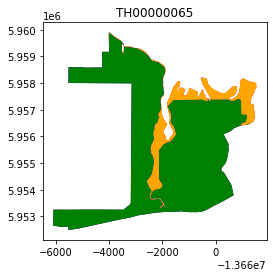

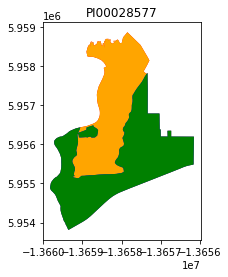

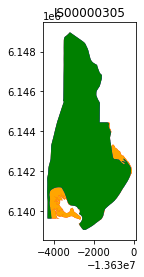

In [46]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.at[i,"ST_CODE"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [45]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(7195, 1)
7079 precincts w/ a difference of 0 km^2
113 precincts w/ a difference between 0 and .1 km^2
3 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


#### Display the 3 precincts w/ a difference between .1 and .5 km^2

Text(0.5, 1.0, 'IS00000305')

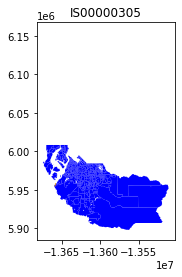

In [56]:
base = diff.plot(color="red")
source_geoms[source_geoms['ST_CODE'] == 'PI00028577'].plot(color="orange",ax=base)
vest_geoms[vest_geoms['county'] == 'PI'].plot(color="blue",ax=base)
base.set_title(name)